In [1]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

from math import sqrt

drive.mount('/content/drive')

Summary = pd.read_csv('drive/My Drive/Colab Notebooks/Viscosity Models Data - Summary.csv')
Summary.dropna(inplace=True)
print(Summary.head())

Synthetic = pd.read_csv('drive/My Drive/Colab Notebooks/Mix Data - Synthetic CSV.csv')
Synthetic.dropna(inplace=True)
print(Synthetic.head())

Mounted at /content/drive
       Sample ID  Power Law Index  Dynamic YS  Brookfield       Ares  \
0     80 35 70-0            0.685      48.875    559000.0   749000.0   
1     80 50 70-0            0.750      35.630    426000.0   509000.0   
2  85 35 0-70 #2            0.615     102.835   1380000.0  1640000.0   
3    85 35 15-55            0.680      92.855   1880000.0  2580000.0   
4    85 35 30-40            0.640     126.875   2050000.0  2310000.0   

   Syringe Pump    Average  Solids Loading  Percent Fe-S  Percent Med  \
0      755000.0   688000.0            80.0            35           70   
1      524000.0   486000.0            80.0            50           70   
2     1980000.0  1670000.0            85.0            35            0   
3     2180000.0  2210000.0            85.0            35           15   
4     2920000.0  2430000.0            85.0            35           30   

   % of Theo  Percent slump  % of Theo (test end)  
0       27.8           41.7                  16.7 

# Average Viscosity-

In [2]:
percent = 0.15

rand = []
for x in range(len(Synthetic)):
  rand.append(random.uniform(-1, 1))

Synthetic['Percent Error'] = Synthetic['Viscosity'] - Synthetic['Viscosity']*percent*rand

In [3]:
# Polynomial Regression

percent = 0.1
iterations = 1000
Train = []
Validation = []
Test = []

RMSE_Train = []
RMSE_Validation = []
RMSE_Test = []

for i in range(0, iterations):
  rand = []
  for x in range(len(Synthetic)):
    rand.append(random.uniform(-1, 1))

  Synthetic['Percent Error'] = Synthetic['Viscosity'] - Synthetic['Viscosity']*percent*rand

  # synthetic data is training data
  B_y_train = Synthetic['Percent Error']
  B_x_train = Synthetic[['Solids Loading', 'Percent Fe-S', 'Percent Med']]

  poly = PolynomialFeatures(degree=3, include_bias=False)
  Z = poly.fit_transform(B_x_train)

  # Split into training and validation datasets
  X_train, X_val, y_train, y_val = train_test_split(Z, B_y_train, test_size=0.2)

  # Initialize model
  model = LinearRegression()

  # Early stopping parameters
  best_val_loss = float('inf')
  patience_counter = 0
  patience_limit = 10  # Number of epochs to wait before stopping
  epochs = 100  # Total epochs to train

  # Training loop with early stopping
  for epoch in range(epochs):
      model.fit(X_train, y_train)

      # Validate the model
      y_val_prediction = model.predict(X_val)
      val_loss = mean_squared_error(y_val, y_val_prediction)

      # Check for early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0  # Reset counter
      else:
          patience_counter += 1

      if patience_counter >= patience_limit:
          #print(f"Early stopping at epoch {epoch+1} \n")
          break

  # Prepare the real data for testing
  # real data will be testing data
  Summary['Average'] = (Summary['Brookfield'] + Summary['Syringe Pump'] + Summary['Ares'])/3

  y_test = Summary['Average']
  X_test = Summary[['Solids Loading', 'Percent Fe-S', 'Percent Med']]
  X_test = poly.fit_transform(X_test)

  # Evaluate the trained model on validation data
  y_train_prediction = model.predict(X_train)
  y_test_prediction = model.predict(X_test)

  # Display predictions
  pred = pd.DataFrame(X_test, columns=poly.get_feature_names_out())
  pred['True Values'] = y_test.values
  pred['Predicted'] = y_test_prediction

  Train.append(r2_score(y_train, y_train_prediction))
  Validation.append(r2_score(y_val, y_val_prediction))
  Test.append(r2_score(y_test, y_test_prediction))

  RMSE_Train.append(sqrt(mean_squared_error(y_train, y_train_prediction)))
  RMSE_Validation.append(sqrt(mean_squared_error(y_val, y_val_prediction)))
  RMSE_Test.append(sqrt(mean_squared_error(y_test, y_test_prediction)))

print("Train RMSE: %.4f" % float(sum(RMSE_Train)/len(RMSE_Train)))
print("Validation RMSE: %.4f" % float(sum(RMSE_Validation)/len(RMSE_Validation)))
print("Test RMSE:  %.4f" % float(sum(RMSE_Test)/len(RMSE_Test)), '\n')

print('Avg Train r^2: %.4f' % float(sum(Train)/len(Train)))
print('Avg Validation r^2: %.4f' % float(sum(Validation)/len(Validation)))
print('Avg Test r^2: %.4f' % float(sum(Test)/len(Test)))

Train RMSE: 1609178.8275
Validation RMSE: 1372160.6301
Test RMSE:  1318009.0102 

Avg Train r^2: 0.9722
Avg Validation r^2: 0.9615
Avg Test r^2: 0.9076


# Printability-

In [5]:
user_printable = []
percent_theo_cutoff = 50

for x in Summary['% of Theo (test end)']:
    if x < percent_theo_cutoff:
        user_printable.append('No')
    else:
        user_printable.append('Yes')

Summary['User Printable'] = user_printable
counts = Summary['User Printable'].value_counts()

print(counts)

balanced_Summary = Summary.drop(Summary[Summary['User Printable'] == 'No'].sample(int(counts[0]-counts[1])).index)

counts = balanced_Summary['User Printable'].value_counts()
print(counts)

User Printable
No     13
Yes     9
Name: count, dtype: int64
User Printable
No     9
Yes    9
Name: count, dtype: int64


<ipython-input-5-28a3475453d8>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balanced_Summary = Summary.drop(Summary[Summary['User Printable'] == 'No'].sample(int(counts[0]-counts[1])).index)


<ipython-input-8-ca92ed350746>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balanced_Summary = Summary.drop(Summary[Summary['User Printable'] == 'No'].sample(int(counts[0]-counts[1])).index)


Average Accuracy: 0.8333333333333334
    Predicted  Probability (Yes)
0          No           0.113674
1          No           0.113798
2          No           0.114636
3          No           0.115846
4          No           0.115938
..        ...                ...
558        No           0.580514
559       Yes           0.938863
560       Yes           0.951211
561       Yes           0.834474
562       Yes           0.725004

[563 rows x 2 columns]
Predicted                 Yes
Probability (Yes)    0.964749
Name: 46, dtype: object


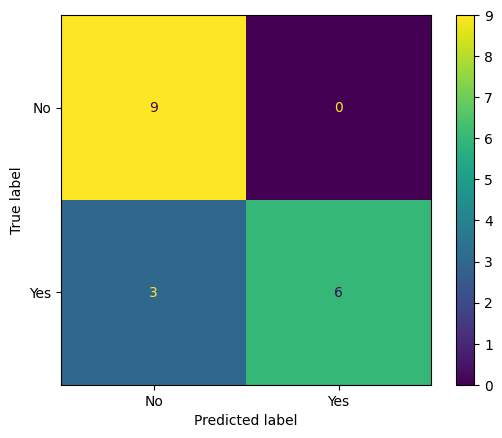

In [8]:
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt

iterations = 1000

full_y_true = []
full_y_pred = []
full_accuracy = []

for i in range(0, iterations):
    user_printable = []
    percent_theo_cutoff = 50

    for x in Summary['% of Theo (test end)']:
        if x < percent_theo_cutoff:
            user_printable.append('No')
        else:
            user_printable.append('Yes')

    Summary['User Printable'] = user_printable
    counts = Summary['User Printable'].value_counts()

    balanced_Summary = Summary.drop(Summary[Summary['User Printable'] == 'No'].sample(int(counts[0]-counts[1])).index)
    counts = balanced_Summary['User Printable'].value_counts()

    y = balanced_Summary['User Printable']
    X = balanced_Summary[['Solids Loading', 'Percent Fe-S', 'Percent Med', 'Average']]

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=9, shuffle=True)

    # Initialize lists to store true labels, predictions, and probabilities
    all_y_true = []
    all_y_pred = []
    all_probabilities = []

    # Perform Stratified K-Fold cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create and train the SVM classifier with probability=True
        clf1 = svm.SVC(kernel='rbf', probability=True)
        clf1.fit(X_train, y_train)

        # Predict the response for test dataset
        y_pred = clf1.predict(X_test)

        # Get prediction probabilities
        probabilities = clf1.predict_proba(X_test)

        # Append true and predicted labels, and probabilities to the lists
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_probabilities.extend(probabilities)

    # Create a DataFrame for results
    results_df = pd.DataFrame({
        'True': all_y_true,
        'Predicted': all_y_pred,
        'Probability (Yes)': [prob[1] for prob in all_probabilities]
    })

    # Print the results table
    #print(results_df)

    # Calculate the overall confusion matrix
    confusion_matrix = metrics.confusion_matrix(all_y_true, all_y_pred)

    full_y_true.append(all_y_true)
    full_y_pred.append(all_y_pred)

    # Print average accuracy
    average_accuracy = metrics.accuracy_score(all_y_true, all_y_pred)
    full_accuracy.append(average_accuracy)

# Print overall average accuracy
print("Average Accuracy:", sum(full_accuracy) / len(full_accuracy))

# Function to predict class and probability for new data
def predict_new_data(model, new_data):
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)

    result_df = pd.DataFrame({
        'Predicted': predictions,
        'Probability (Yes)': [prob[1] for prob in probabilities]
    })

    return result_df


Synthetic['Average'] = Synthetic['Percent Error']
new_data = Synthetic[['Solids Loading','Percent Fe-S', 'Percent Med', 'Average']]

result_df = predict_new_data(clf1, new_data)
print(result_df)

max_prob_row = result_df.loc[result_df['Probability (Yes)'].idxmax()]
print(max_prob_row)

from itertools import chain
full_y_true = list(chain.from_iterable(full_y_true))
full_y_pred = list(chain.from_iterable(full_y_pred))

confusion_matrix = metrics.confusion_matrix(full_y_true, full_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['No', 'Yes'])
cm_display.plot()
plt.savefig('drive/My Drive/Colab Notebooks/confusion.png', transparent=True)
#plt.show()


In [ ]:
# Predict most printable mix based on generated model

Synthetic['Average'] = Synthetic['Percent Error']
new_data = Synthetic[['Solids Loading','Percent Fe-S', 'Percent Med', 'Average']]

def predict_new_data(model, new_data):
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)

    # Create a DataFrame for results
    result_df = pd.DataFrame({
        'Predicted': predictions,
        'Probability (Yes)': [prob[1] for prob in probabilities]
    })

    # Concatenate input values with the predictions
    result_df = pd.concat([new_data.reset_index(drop=True), result_df], axis=1)

    # Find the row with the maximum probability
    max_prob_row = result_df.loc[result_df['Probability (Yes)'].idxmax()]

    print("Row with Maximum Probability:")
    print(max_prob_row)

    return result_df

predict_new_data(clf1, new_data)

Row with Maximum Probability:
Solids Loading                  89.0
Percent Fe-S                      50
Percent Med                       10
Average              11401960.669887
Predicted                        Yes
Probability (Yes)           0.964241
Name: 220, dtype: object


,Solids Loading,Percent Fe-S,Percent Med,Average,Predicted,Probability (Yes)
0,80.0,35,0,1.329234e+05,No,0.117906
1,81.0,35,0,1.908678e+05,No,0.117734
2,82.0,35,0,3.238626e+05,No,0.117615
3,82.5,35,0,4.289076e+05,No,0.117796
4,83.0,35,0,5.104593e+05,No,0.118107
...,...,...,...,...,...,...
558,86.0,65,70,5.287333e+06,Yes,0.619549
559,87.0,65,70,8.365975e+06,Yes,0.932571
560,88.0,65,70,1.213694e+07,Yes,0.962945
561,89.0,65,70,2.211767e+07,Yes,0.812884
